## Evaluate Pearson correlation score and cell type accuracy score

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import umap
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

from sklearn.neighbors import NearestNeighbors
import scipy.stats

### Load results

In [2]:
res_path = "Results/INSPIRE_registration_starmapplus"
adata_0_ours = sc.read_h5ad(res_path + "/adata_st_list_0_loc_aligned.h5ad")
adata_1_ours = sc.read_h5ad(res_path + "/adata_st_list_1_loc_aligned.h5ad")

In [3]:
print("Load data 1...")

data_dir = "3d-alignment/STARmapPLUS"
adata_1 = sc.read_h5ad(data_dir + "/adata_8m_disease_rep1.h5ad")
adata_1.var_names_make_unique()

print("Load data 2...")

data_dir = "3d-alignment/STARmapPLUS"
adata_2 = sc.read_h5ad(data_dir + "/adata_8m_disease_rep2.h5ad")
adata_2.var_names_make_unique()

Load data 1...
Load data 2...


In [4]:
adata_st_list = [adata_1, adata_2]

adata_0 = adata_st_list[0]
adata_0.obs.index = adata_0.obs.index + "-1"

adata_1 = adata_st_list[1]
adata_1.obs.index = adata_1.obs.index + "-0"

In [5]:
adata_0.obsm["loc_ours"] = adata_1_ours[adata_0.obs.index, :].obsm["loc_aligned"]
adata_1.obsm["loc_ours"] = adata_0_ours[adata_1.obs.index, :].obsm["loc_aligned"]
adata_0.obs["celltype"] = adata_1_ours[adata_0.obs.index, :].obs["top_level_cell_type"]
adata_1.obs["celltype"] = adata_0_ours[adata_1.obs.index, :].obs["top_level_cell_type"]

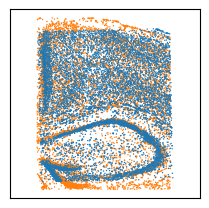

In [6]:
s = 1
f = plt.figure(figsize=(2.45, 2.45))

ax2 = f.add_subplot(1,1,1)
ax2.scatter(adata_1.obsm["loc_ours"][:,0], -adata_1.obsm["loc_ours"][:,1], facecolors="tab:orange", s=s, rasterized=True, marker='o', edgecolors='none')
ax2.scatter(adata_0.obsm["loc_ours"][:,0], -adata_0.obsm["loc_ours"][:,1], facecolors="tab:blue", s=s, rasterized=True, marker='o', edgecolors='none')
ax2.axis('equal')
ax2.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

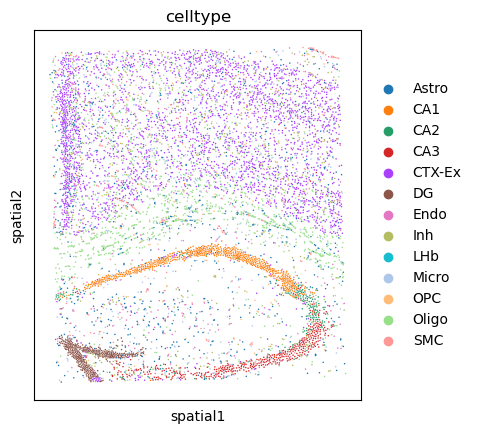

In [7]:
adata_0.obsm["spatial"] = adata_0.obsm["loc_ours"]
sc.pl.spatial(adata_0, color="celltype", spot_size=100.)

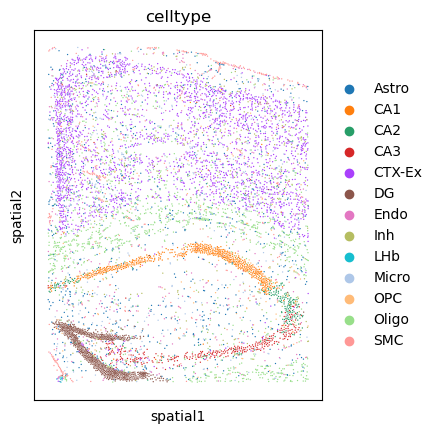

In [8]:
adata_1.obsm["spatial"] = adata_1.obsm["loc_ours"]
sc.pl.spatial(adata_1, color="celltype", spot_size=100.)

### Calculate the scores

In [9]:
k = 6

neigh = NearestNeighbors(n_neighbors=k, metric="euclidean")
neigh.fit(adata_1.obsm["loc_ours"])
NN = neigh.kneighbors(adata_0.obsm["loc_ours"], k, return_distance=False)

PCC = []
for i in range(NN.shape[0]):
    x0 = adata_0.X[i, :]
    x1_mat = adata_1.X[NN[i, :], :]
    pcc_cell = np.corrcoef(x0.reshape((1,-1)), x1_mat)[0, :][1:]
    PCC.append(np.max(pcc_cell))

print("Pearson correlation score =", np.mean(PCC))

Pearson correlation score = 0.2562931829758295


In [10]:
neigh = NearestNeighbors(n_neighbors=k, metric="euclidean")
neigh.fit(adata_1.obsm["loc_ours"])
NN = neigh.kneighbors(adata_0.obsm["loc_ours"], k, return_distance=False)

acc = []
for i in range(NN.shape[0]):
    ct_0 = adata_0.obs["celltype"][i]
    ct_1_nn = adata_1.obs["celltype"][NN[i, :]]
    s_same = np.sum(ct_1_nn == ct_0)
    if s_same == 0:
        acc.append(0)
    else:
        acc.append(1)

print("Cell type accuracy score =", np.mean(acc))

Cell type accuracy score = 0.7369899828976301
